In [1]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]
C:\Users\lpott\OneDrive\Documents\Northeastern University\Classes\EECE 7398 Verifiable Machine Learning\EECE7398_Final_Project\src\visualizations.py:143: DeprecationWarning: invalid escape sequence '\m'
  axes[0].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_robust.mean(),lambda_robust.var()))
C:\Users\lpott\OneDrive\Documents\Northeastern University\Classes\EECE 7398 Verifiable Machine Learning\EECE7398_Final_Project\src\visualizations.py:146: D

In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [4]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 1e-3
args.batch_size= 256
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [0.1,0.9]
args.save_model = ""
args.dataset = "TRACE"
args.loss_wrapper="rhc_rank"
args.weight = 1.0
args.sigma = 1.0

In [5]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 5. Framingham
# 6. rott2
# 7. dataDIVAT1
# 8. prostate
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [6]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [7]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [8]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

wrapper = loss_wrapper(args.loss_wrapper)

# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(wrapper(clf_robust,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(wrapper(clf_fragile,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)

In [9]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1208.1896 Time=0.0155
[ 1:   5]: eps=0.00000000 Loss=1113.4291 Time=0.0097
Epoch time: 0.0666, Total time: 0.0666
Evaluating...
[ 1:   1]: eps=0.00000000 Loss=870.5069 Time=0.0050
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1102.2609 Time=0.0093
[ 2:   5]: eps=0.00000000 Loss=981.6653 Time=0.0087
Epoch time: 0.0593, Total time: 0.1259
Evaluating...
[ 2:   1]: eps=0.00000000 Loss=767.6305 Time=0.0050
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=941.9180 Time=0.0090
[ 3:   5]: eps=0.00000000 Loss=866.4784 Time=0.0081
Epoch time: 0.0549, Total time: 0.1808
Evaluating...
[ 3:   1]: eps=0.00000000 Loss=673.7291 Time=0.0055
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=813.0798 Time=0.0139
[ 4:   5]: eps=0.00000000 Loss=759.8304 Time=0.0094
Epoch time: 0.0646, Total time: 0.2453
Evaluating...
[ 4:   1]: eps=0.00000000 Loss=589.1846 Time=0.0040
Epoch 5, learning rate [0.001]
[ 5:  

In [10]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1208.1896 Time=0.0217
[ 1:   5]: eps=0.00000000 Loss=1113.4291 Time=0.0152
Epoch time: 0.1042, Total time: 0.1042
Evaluating...
[ 1:   1]: eps=0.00000000 Loss=870.5069 Time=0.0075
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1102.2609 Time=0.0111
[ 2:   5]: eps=0.00000000 Loss=981.6653 Time=0.0101
Epoch time: 0.0698, Total time: 0.1740
Evaluating...
[ 2:   1]: eps=0.00000000 Loss=767.6305 Time=0.0060
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=941.9180 Time=0.0121
[ 3:   5]: eps=0.00000000 Loss=866.4784 Time=0.0121
Epoch time: 0.0886, Total time: 0.2627
Evaluating...
[ 3:   1]: eps=0.00000000 Loss=673.7291 Time=0.0055
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=813.0798 Time=0.0120
[ 4:   5]: eps=0.00000000 Loss=759.8304 Time=0.0112
Epoch time: 0.0800, Total time: 0.3427
Evaluating...
[ 4:   1]: eps=0.00000000 Loss=589.1846 Time=0.0077
Epoch 5, learning rate [0.001]
[ 5:  

In [11]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

In [12]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 1502 total observations, 736 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_32004\671205530.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


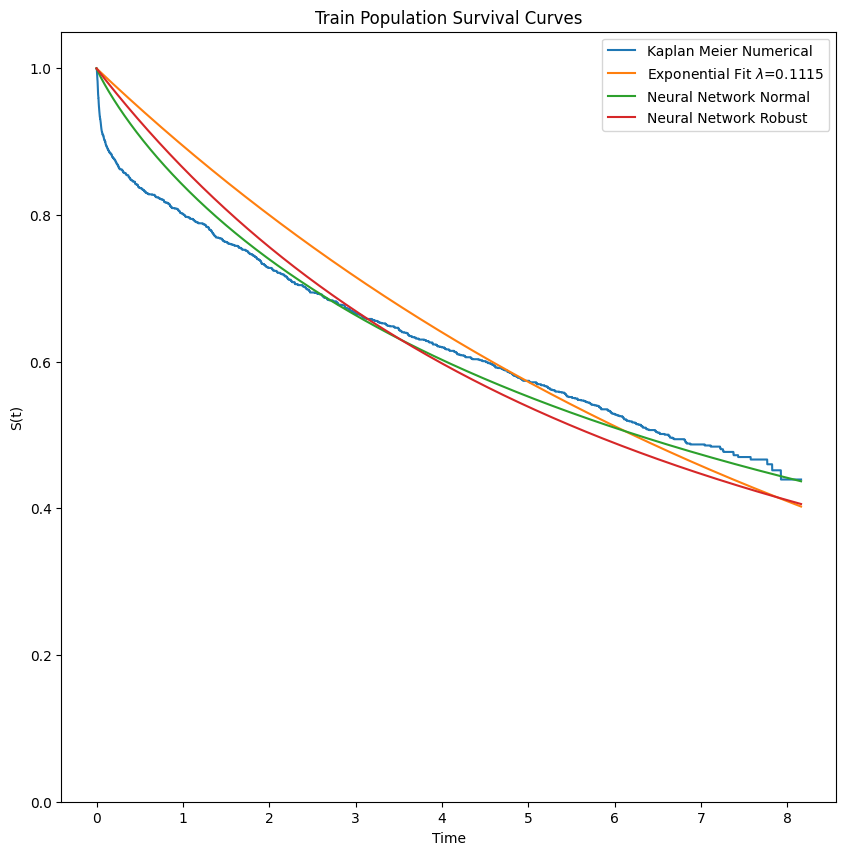

In [13]:
St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

In [14]:
def visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    X,_,_ = dataloader.dataset.tensors


    lambda_robust = clf_robust(X).detach()
    lambda_fragile = clf_fragile(X).detach()

    plot_df = pd.DataFrame({"Lambda Robust": lambda_robust.ravel(), "Lambda Fragile": lambda_fragile.ravel()})

    sns.histplot(data=plot_df, x="Lambda Robust", ax=axes[0], stat="density", legend=False, color="blue")
    axes[0].set_xlim([lambda_fragile.min(), lambda_fragile.quantile(0.99)])
    axes[0].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_robust.mean(),lambda_robust.var()))

    axes[1].set_xlim([lambda_fragile.min(), lambda_fragile.quantile(0.99)])
    axes[1].set_title("$\lambda$ Fragile")
    sns.histplot(data=plot_df, x="Lambda Fragile", ax=axes[1], stat="density", legend=False, color="orange")
    axes[1].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_fragile.mean(),lambda_fragile.var()))

    axes[2].set_xlim([lambda_fragile.min(), lambda_fragile.quantile(0.99)])
    axes[2].set_title("$\lambda$ Overlap")
    sns.histplot(data=plot_df, ax=axes[2], stat="density", legend=True)

    plt.show()

<>:13: DeprecationWarning: invalid escape sequence '\m'
<>:16: DeprecationWarning: invalid escape sequence '\l'


In [15]:
print("Exponential rate parameters: ",1/clf_exp.params_.item())

Exponential rate parameters:  0.11151768589649723


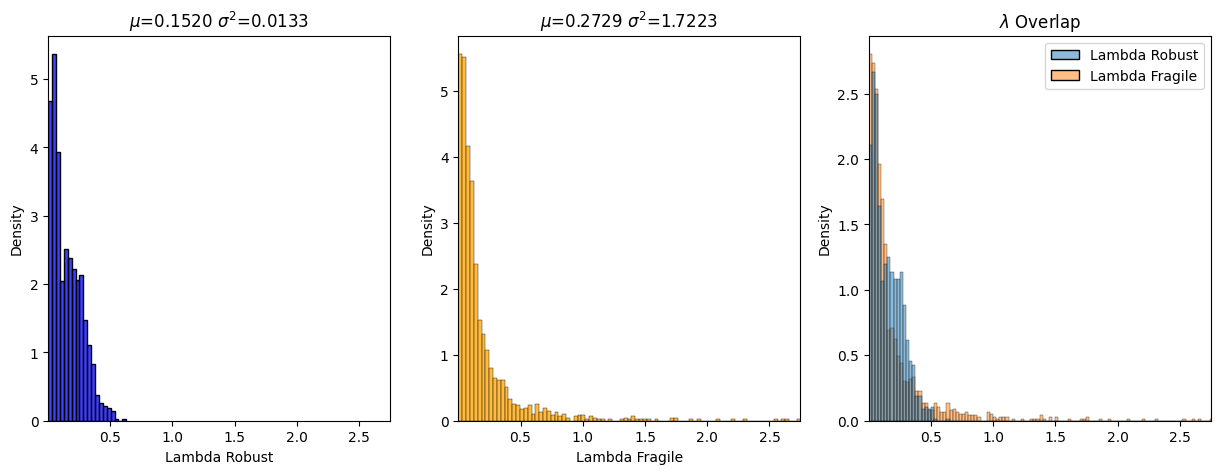

In [16]:
visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader_train)

torch.Size([1502, 1000])


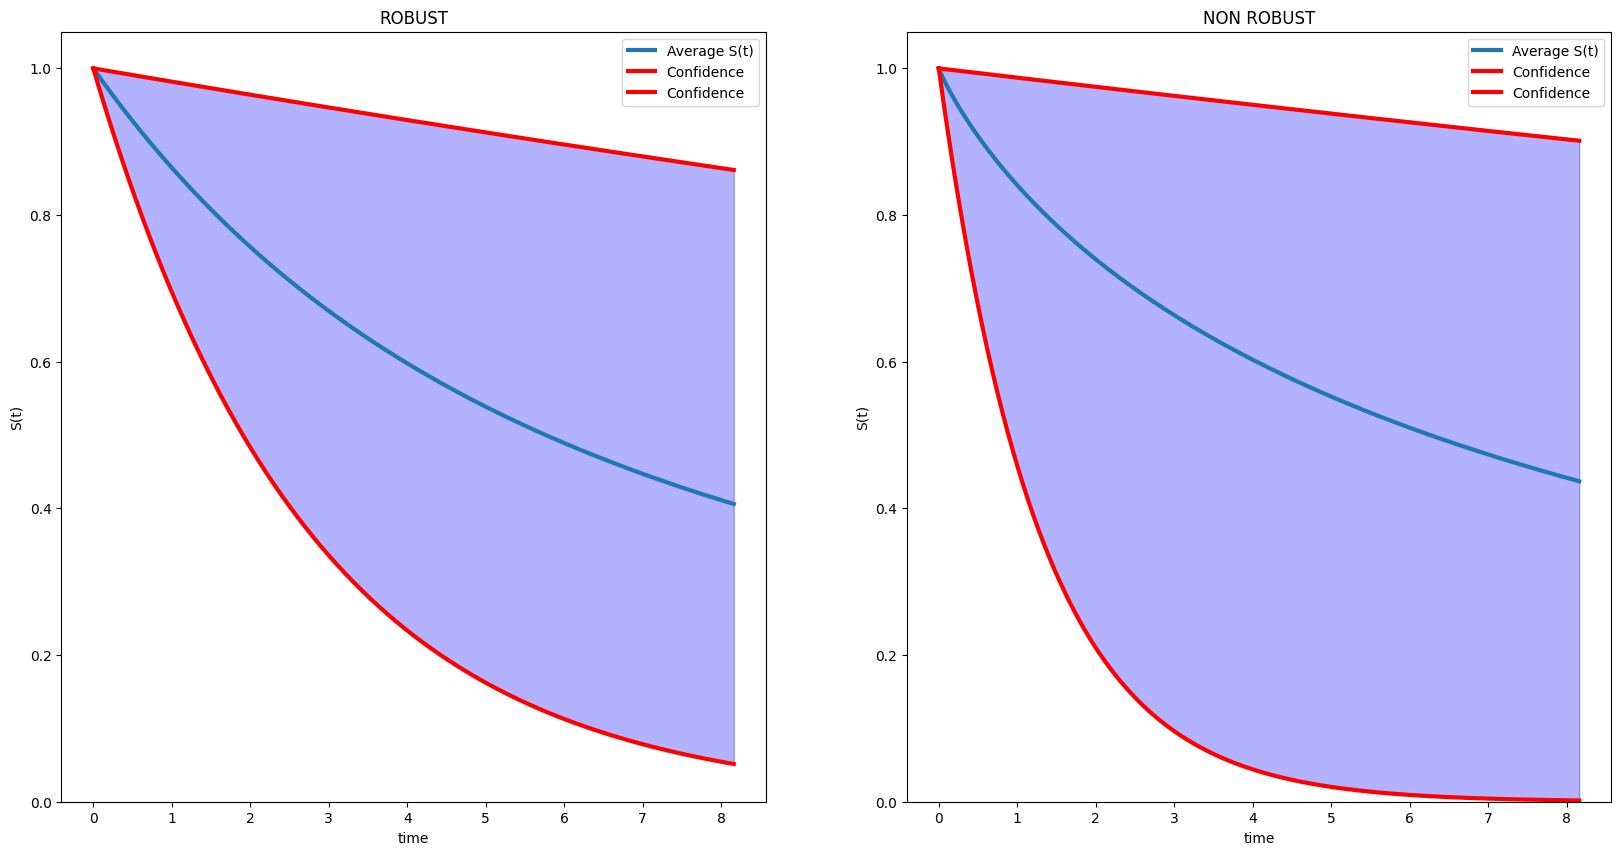

In [17]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_train)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:444: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


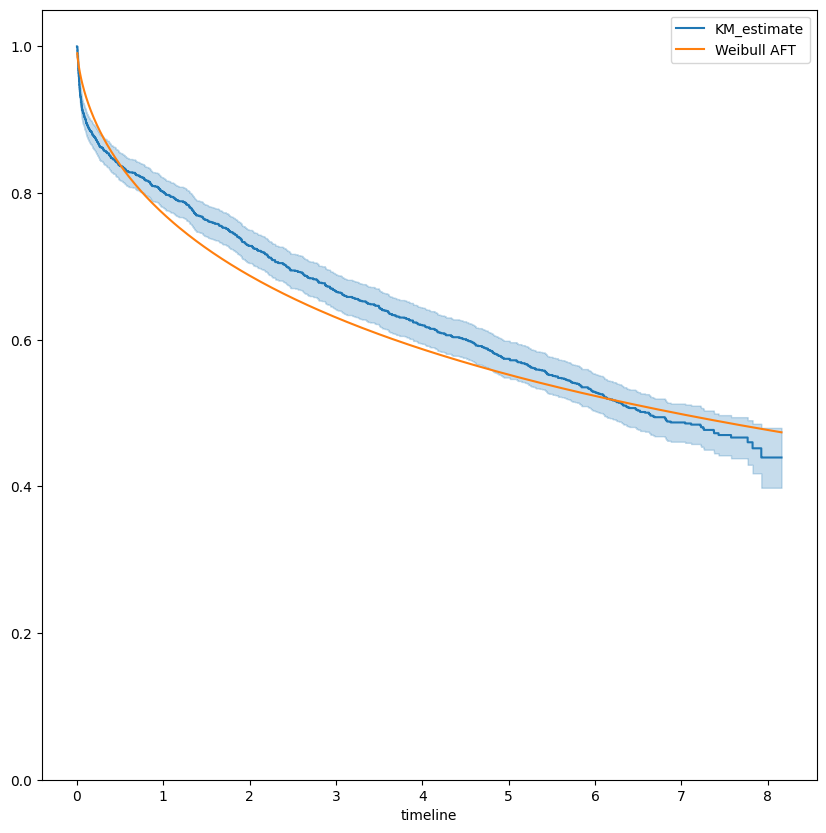

param    covariate           
lambda_  fac_chf_present        -0.430274
         fac_diabetes_present   -0.165574
         fac_sex_M               0.018684
         fac_vf_present         -0.292842
         num_age                -1.041939
         num_wmi                 0.525635
         Intercept               2.702465
rho_     Intercept              -0.493791
dtype: float64


In [18]:
df_train,df_test = load_dataframe(ds_name=args.dataset,drop_first=True)
from lifelines import WeibullAFTFitter
clf_cph = WeibullAFTFitter()
# clf_cph._scipy_fit_method = "SLSQP"
clf_cph.fit(df=df_train,duration_col="time",event_col="event")
kmf.plot()
clf_cph.predict_survival_function(df_train).mean(1).plot(label="Weibull AFT",figsize=(10,10))
plt.legend()
plt.ylim([0,1.05])
plt.show()
print(clf_cph.params_)

In [19]:
print("Lifelines CPH Train CI: {:.3f}".format(clf_cph.score(df_train,scoring_method="concordance_index")))
print("Lifelines CPH Test CI: {:.3f}".format(clf_cph.score(df_test,scoring_method="concordance_index")))

# F_tr = 1-clf_exp.survival_function_at_times(times=T_train.ravel().numpy())
# exp_ci_tr = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())
# exp_ci_te = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())

# print("Lifelines EXP Train CI: {:.3f}".format(exp_ci_tr))
# print("Lifelines EXP Test CI: {:.3f}".format(exp_ci_te))

Lifelines CPH Train CI: 0.738
Lifelines CPH Test CI: 0.746


ROBUST CLF
CI @ eps=10 0.3332805962592897
CI @ eps=5 0.35219907628527214
CI @ eps=2 0.47515486789064443
CI @ eps=1 0.6802563141203217
CI @ eps=0.8 0.7155714469938673
CI @ eps=0.7 0.7257483092295054
CI @ eps=0.6 0.7315012274802744
CI @ eps=0.5 0.7347132138012724
CI @ eps=0.1 0.736931753051984
CI @ eps=0.07 0.7367084662705615
CI @ eps=0.05 0.736649957969547
CI @ eps=0 0.7363144307739334
NONROBUST CLF
CI @ eps=10 0


C:\Users\lpott\OneDrive\Documents\Northeastern University\Classes\EECE 7398 Verifiable Machine Learning\EECE7398_Final_Project\src\metrics.py:16: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + torch.tensor(np.random.randn(ub.isnan().sum(), 1)).ravel()).type(


CI @ eps=5 0.3736519209827484
CI @ eps=2 0.4743500802399557
CI @ eps=1 0.6142338755898592
CI @ eps=0.8 0.6513818705462049
CI @ eps=0.7 0.6710908096593623
CI @ eps=0.6 0.6903746680549453
CI @ eps=0.5 0.7087725436065949
CI @ eps=0.1 0.751170763043769
CI @ eps=0.07 0.7525701860802781
CI @ eps=0.05 0.7533988546701564
CI @ eps=0 0.7547636503448407


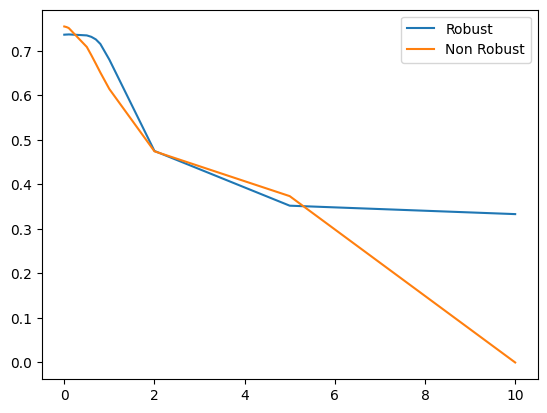

In [20]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

ROBUST CLF
CI @ eps=10 0.3572031783808683
CI @ eps=5 0.377259990019577
CI @ eps=2 0.5020728570880196
CI @ eps=1 0.6940232620628767
CI @ eps=0.8 0.7270546236228935
CI @ eps=0.7 0.7390695174849334
CI @ eps=0.6 0.744481977659207
CI @ eps=0.5 0.7460174273540363
CI @ eps=0.1 0.7397796629687919
CI @ eps=0.07 0.7390695174849334
CI @ eps=0.05 0.7389159725154505
CI @ eps=0 0.7378219646078845
NONROBUST CLF
CI @ eps=10 0
CI @ eps=5 0.38569536678054583
CI @ eps=2 0.48301408775095006
CI @ eps=1 0.6200337798932862
CI @ eps=0.8 0.6544854324210203
CI @ eps=0.7 0.6767110667536754
CI @ eps=0.6 0.697804306936394
CI @ eps=0.5 0.7177267667268051
CI @ eps=0.1 0.7482054431691681
CI @ eps=0.07 0.7470346627768608
CI @ eps=0.05 0.7469195040497486
CI @ eps=0 0.7465356416260412


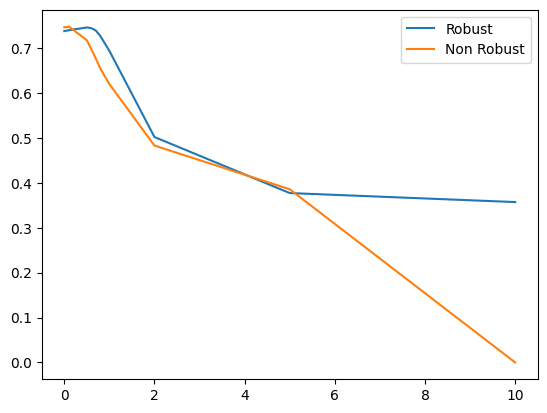

In [21]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

<Figure size 1000x1000 with 0 Axes>

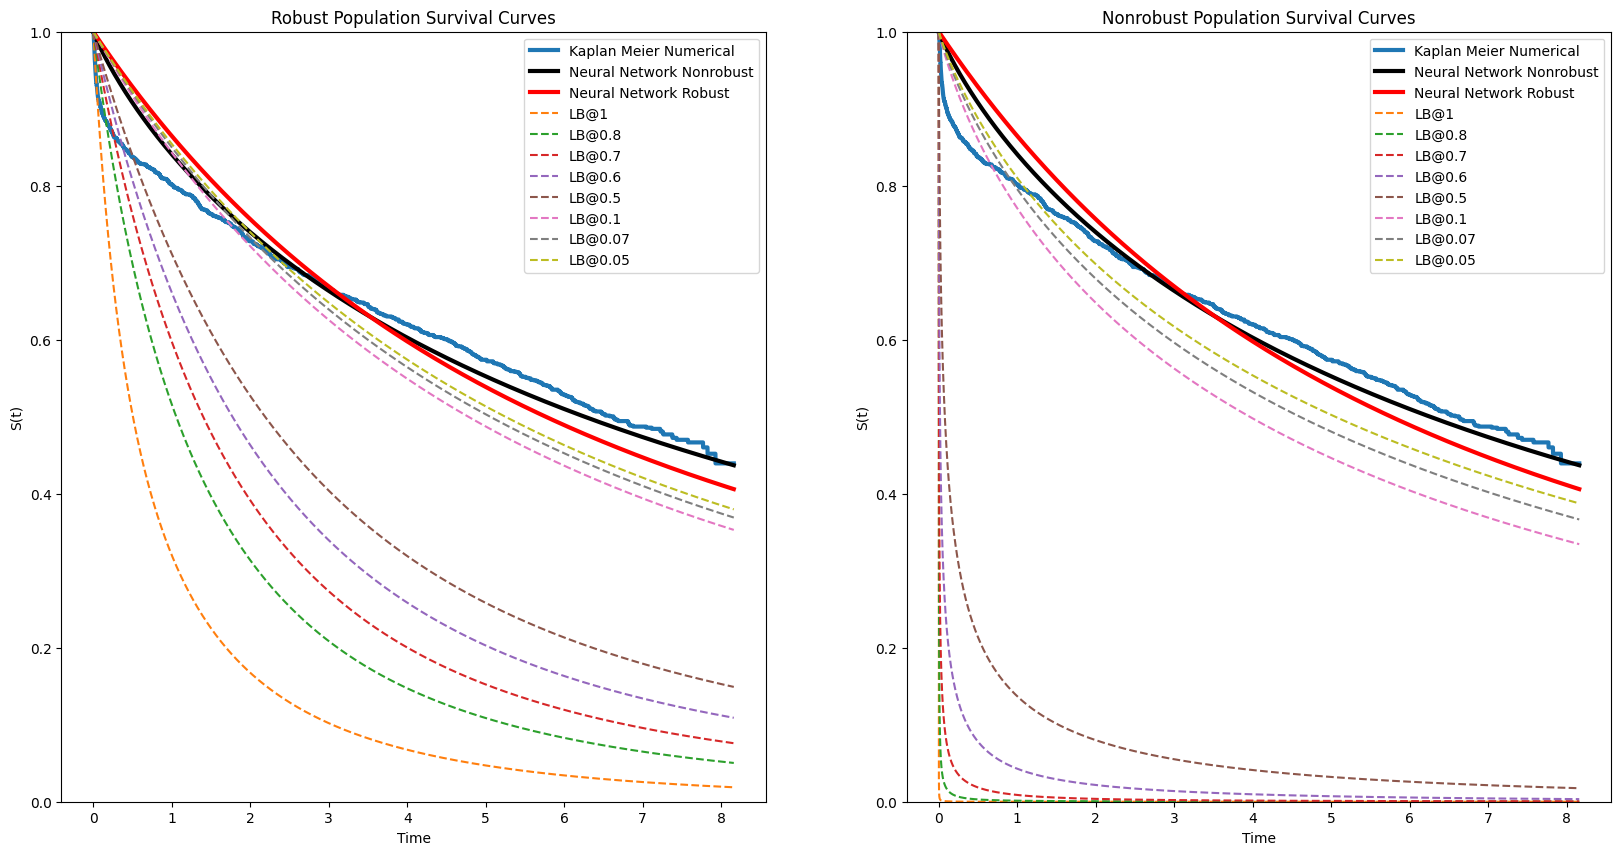

<Figure size 1000x1000 with 0 Axes>

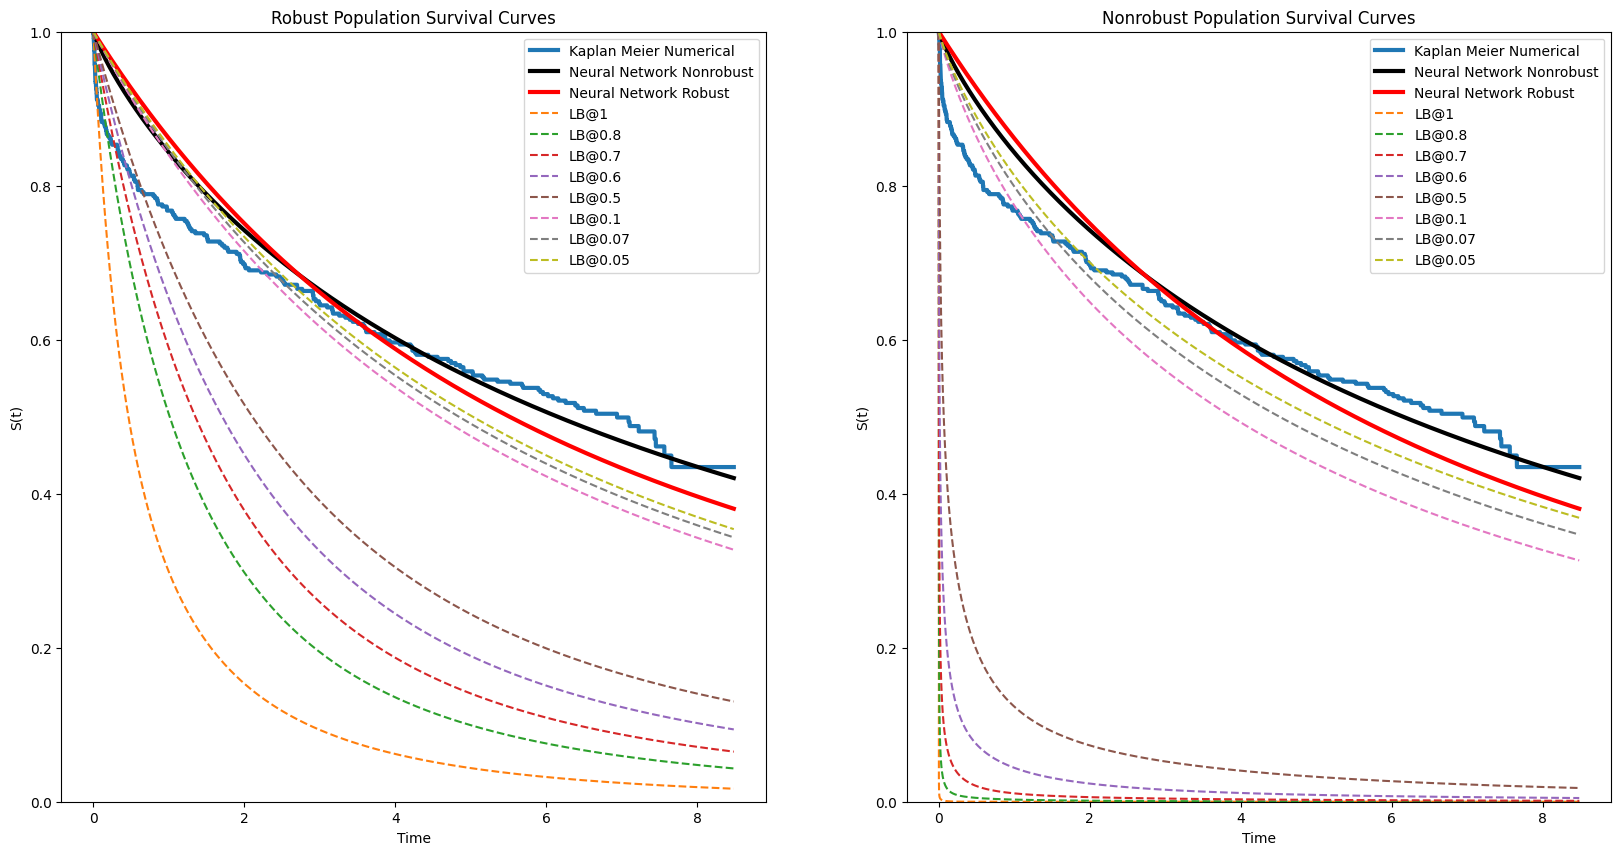

In [22]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

tensor([0.0149, 0.0195, 0.0337, 0.0427, 0.0680, 0.0737, 0.0769, 0.1027, 0.1136,
        0.1210])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


tensor([53.3613, 48.8637, 48.0558, 47.8341, 45.8142, 42.6088, 41.1326, 39.6854,
        39.5902, 37.8051])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


tensor([0.0622, 0.0718, 0.0866, 0.1404, 0.2121, 0.2394, 0.2582, 0.2797, 0.3180,
        0.3330])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


tensor([48.7918, 40.3609, 33.4729, 30.0613, 29.5086, 28.4653, 27.5036, 27.1725,
        25.8408, 25.5800])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.24it/s]


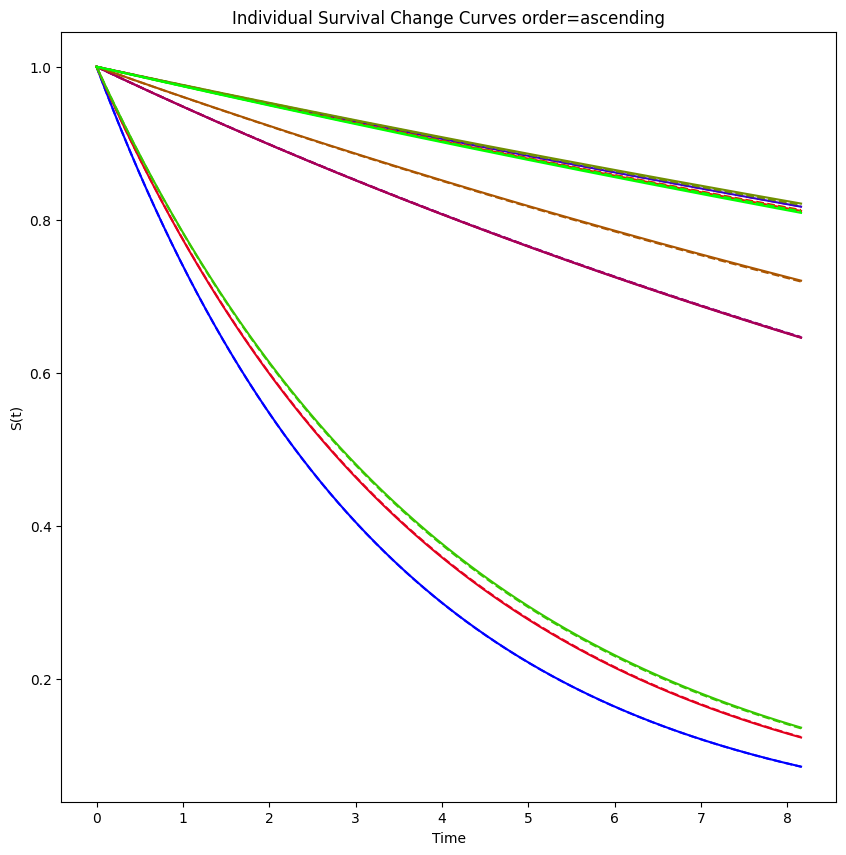

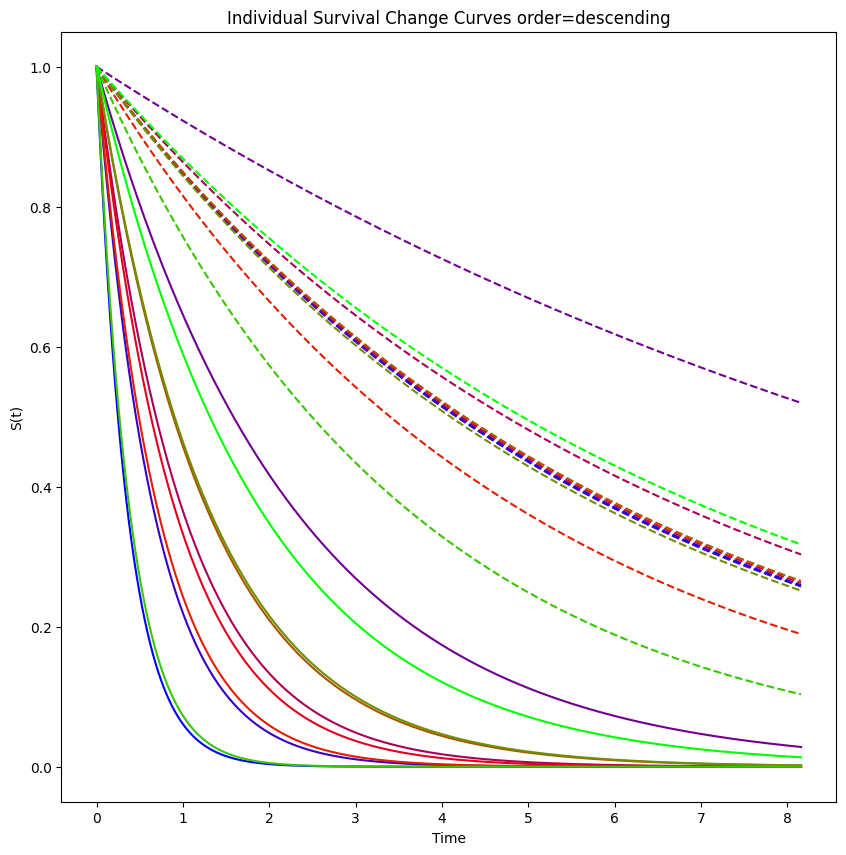

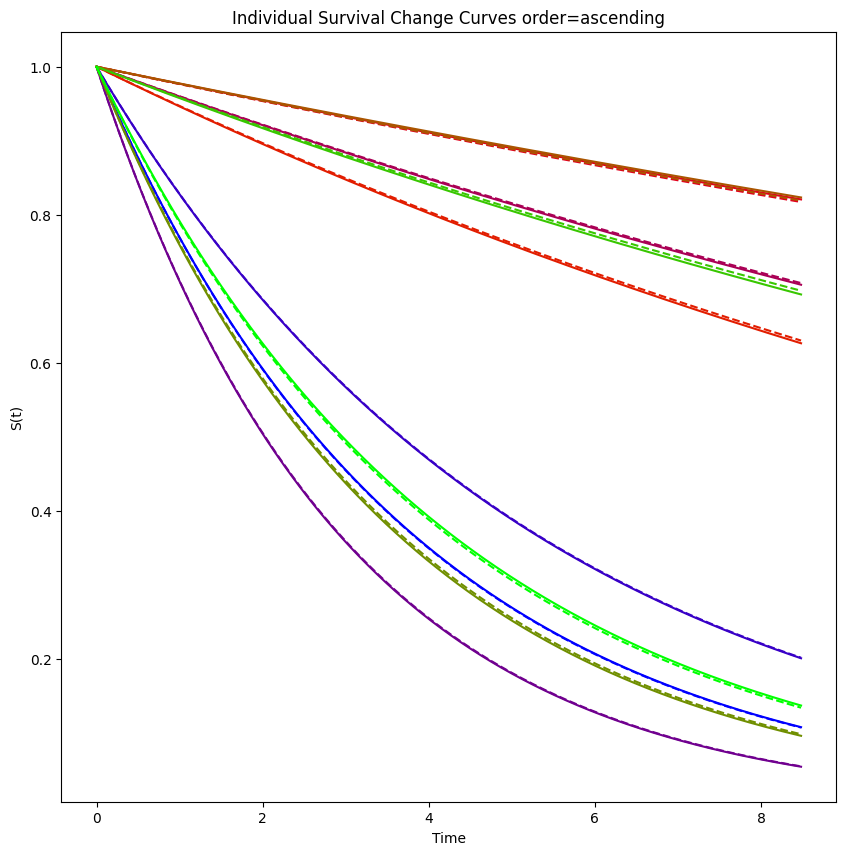

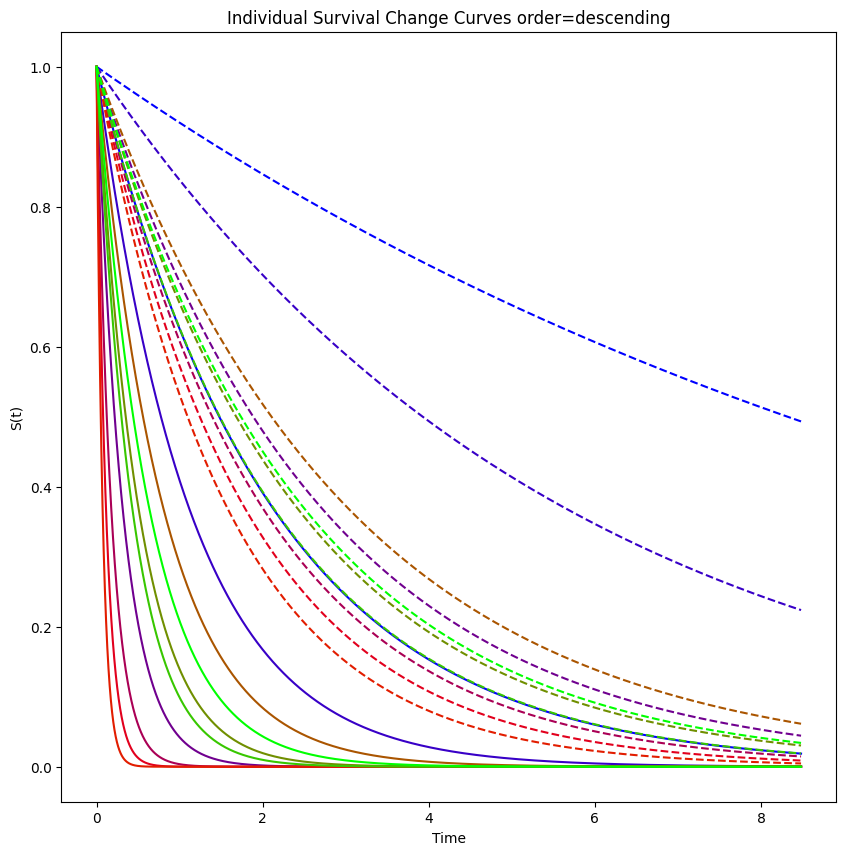

In [23]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

tensor([25.0744, 24.9461, 24.7706, 24.7175, 24.6981, 24.6849, 24.6568, 24.6265,
        24.6248, 24.5203])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


tensor([1.7594, 2.6157, 3.0182, 3.3791, 3.5529, 4.1261, 4.3888, 4.6168, 4.7135,
        4.7367])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.25it/s]


tensor([25.4077, 25.0615, 24.9667, 24.9140, 24.8546, 24.7885, 24.6656, 24.4426,
        24.2518, 24.1526])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.16it/s]


tensor([2.3050, 2.6080, 2.9780, 3.2777, 4.2755, 4.5725, 5.5031, 5.6697, 6.0783,
        6.1316])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


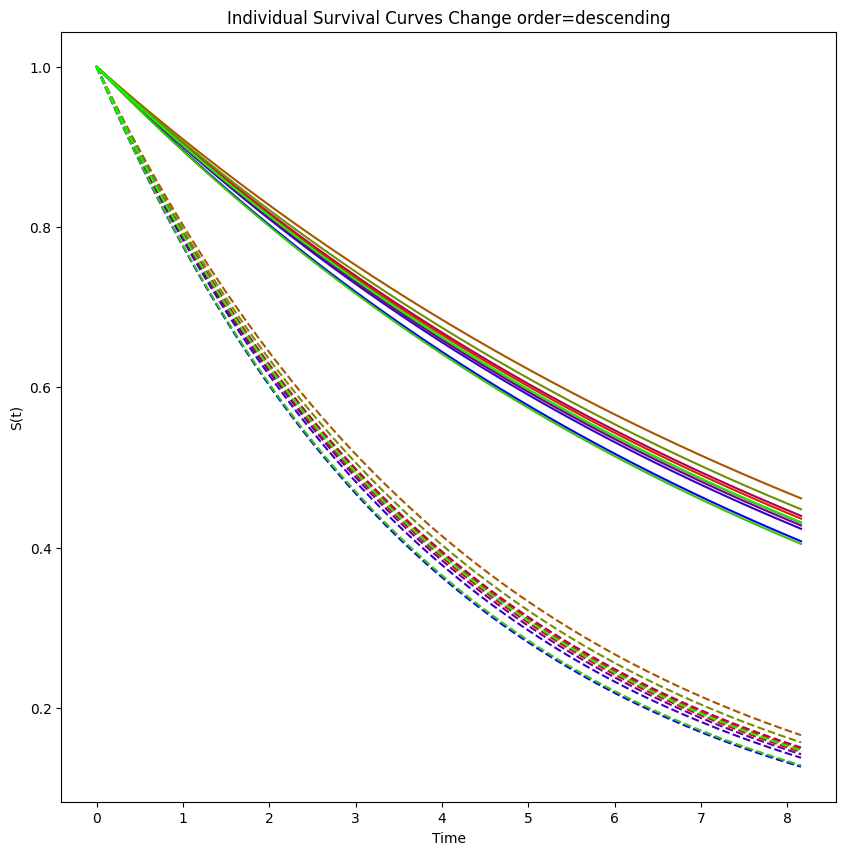

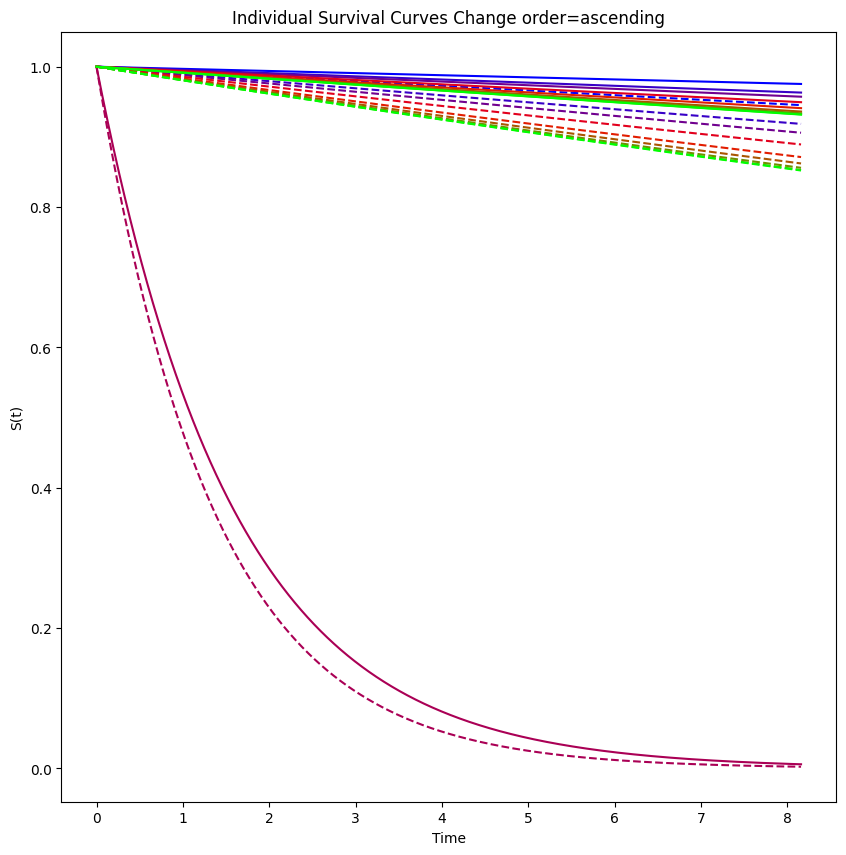

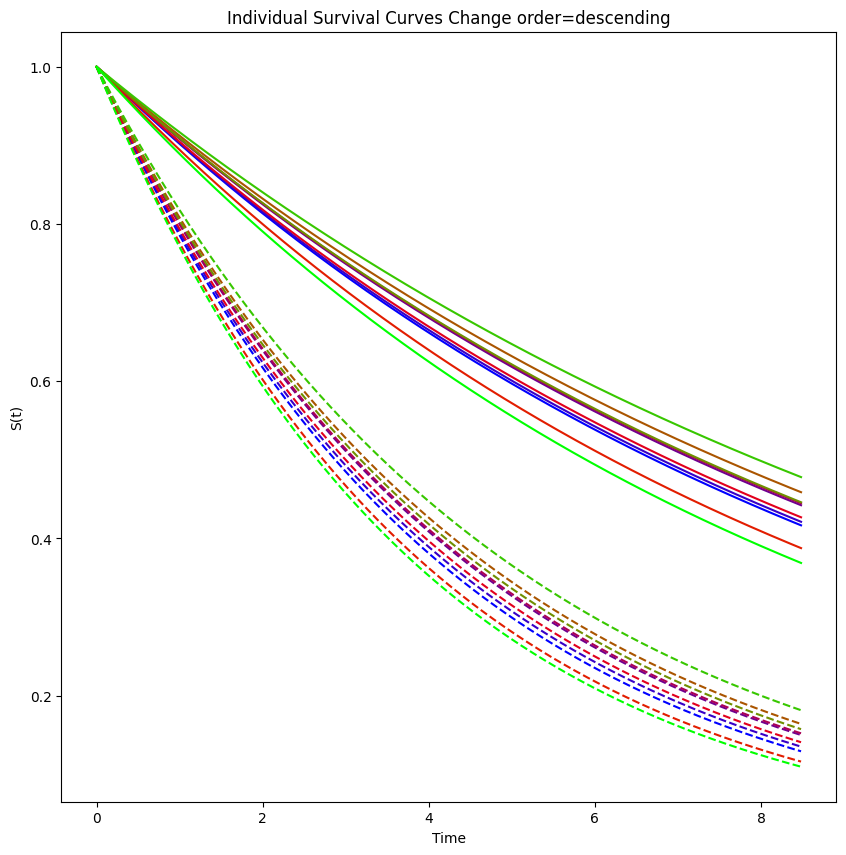

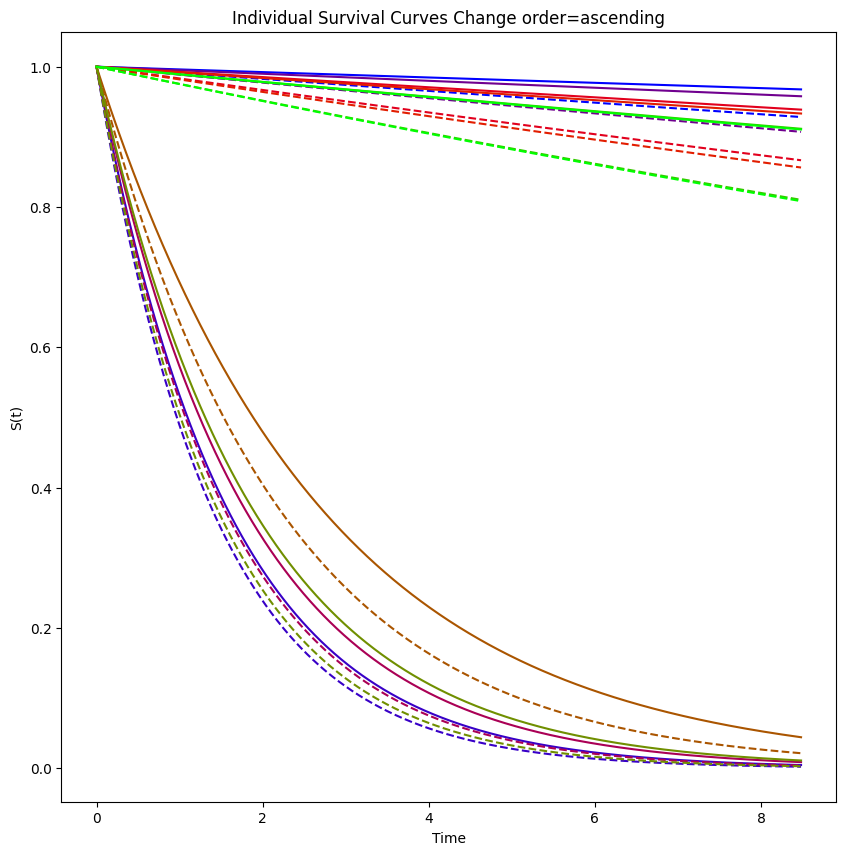

In [24]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")